# Introduction to Survival Analysis: the Kaplan-Meier estimator

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter 
from lifelines.statistics import (logrank_test, 
                                  pairwise_logrank_test, 
                                  multivariate_logrank_test, 
                                  survival_difference_at_fixed_point_in_time_test)

plt.style.use('seaborn')

In [2]:
%config InlineBackend.figure_format = "retina"

## Loading and preparing the data

In [4]:
df = pd.read_csv("../data/telco_customer_churn.csv")
df["churn"] = [1 if x == "Yes" else 0 for x in df["Churn"]]

print(f"Shape of the DataFrame: {df.shape}")
print(f"Number of unique users in the DataFrame: {df['customerID'].nunique()}")
df.head()

Shape of the DataFrame: (7043, 22)
Number of unique users in the DataFrame: 7043


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.5,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1


## Kaplan-Meier Estimate

### General survival curve

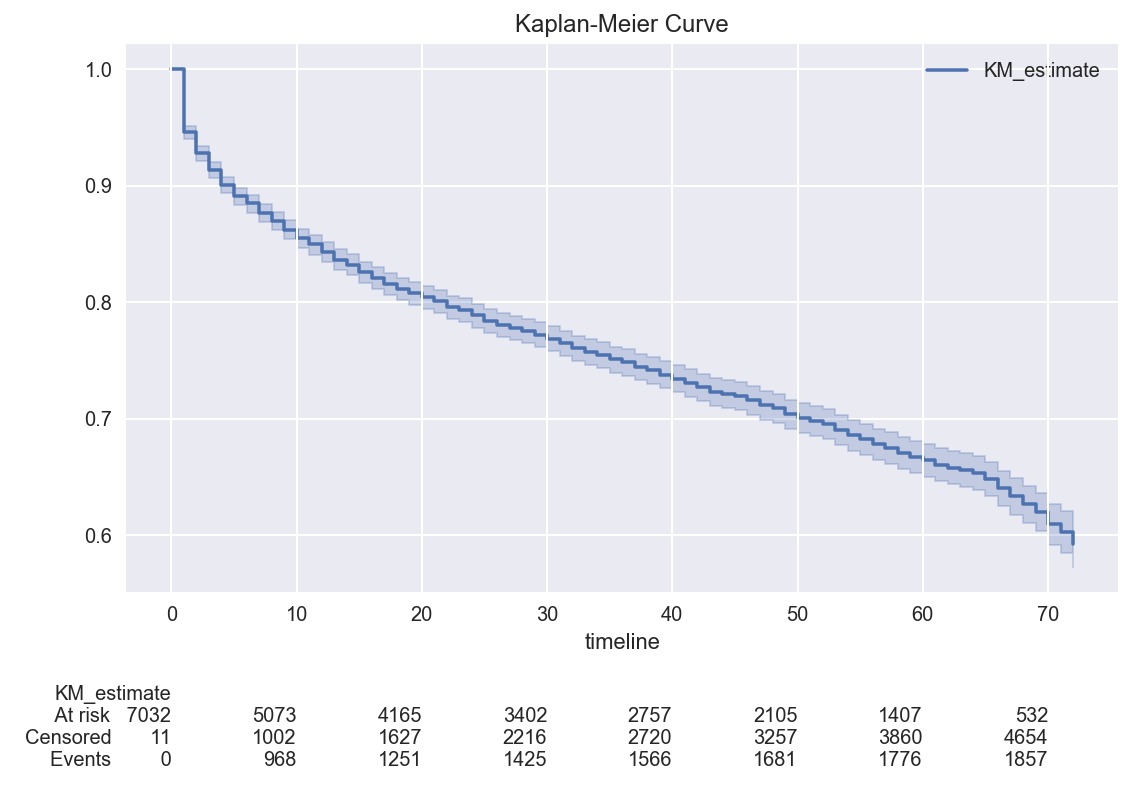

In [5]:
T = df["tenure"]
E = df["churn"]

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

kmf.plot(at_risk_counts=True)
plt.title("Kaplan-Meier Curve");

In [6]:
kmf.median_survival_time_

inf

### Survival curves for each payment method

In [7]:
df["PaymentMethod"].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

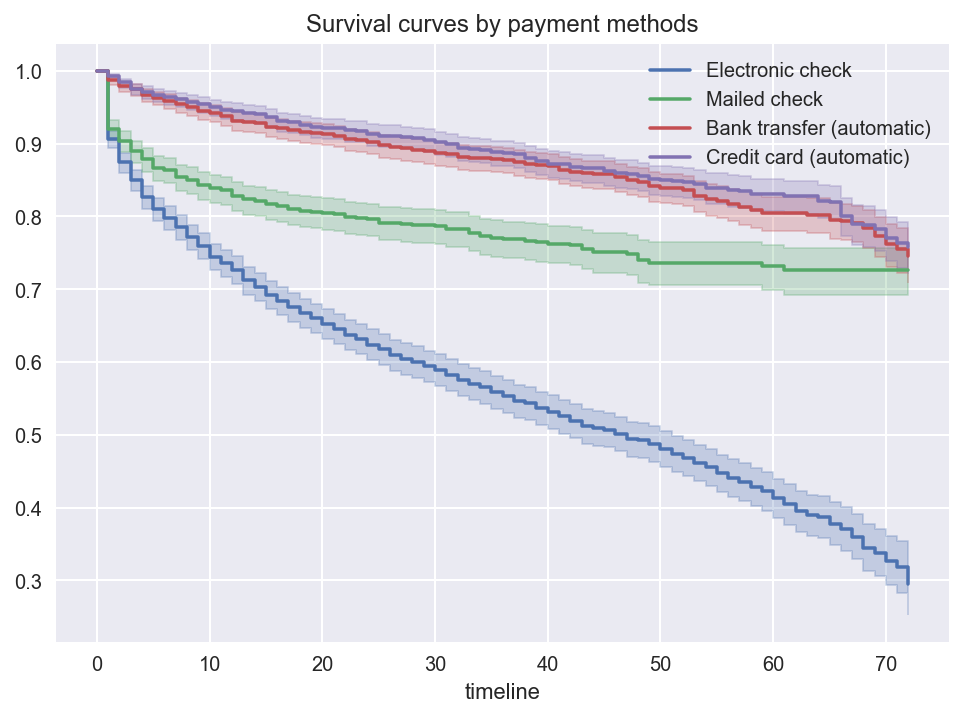

In [8]:
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for payment_method in df["PaymentMethod"].unique():
    
    flag = df["PaymentMethod"] == payment_method
    
    kmf.fit(T[flag], event_observed=E[flag], label=payment_method)
    kmf.plot(ax=ax)

plt.title("Survival curves by payment methods");

### The log-rank test

In [9]:
credit_card_flag = df["PaymentMethod"] == "Credit card (automatic)"
bank_transfer_flag = df["PaymentMethod"] == "Bank transfer (automatic)"

results = logrank_test(T[credit_card_flag], 
                       T[bank_transfer_flag], 
                       E[credit_card_flag], 
                       E[bank_transfer_flag])
results.print_summary()

/opt/homebrew/Caskroom/miniforge/base/envs/medium/lib/python3.8/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.87 0.35      1.51

In [10]:
results = pairwise_logrank_test(df["tenure"], df["PaymentMethod"], df["churn"])
results.print_summary()

/opt/homebrew/Caskroom/miniforge/base/envs/medium/lib/python3.8/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                                                   test_statistic      p  -log2(p)
Bank transfer (automatic) Credit card (automatic)            0.87   0.35      1.51
                          Electronic check                 510.04 <0.005    372.74
                          Mailed check                      51.07 <0.005     40.03
Credit card (automatic)   Electronic check                 539.74 <0.005    394.21
                          Mailed check                      64.82 <0.005     50.11
Electronic check          Mailed check                     152.46 <0.005    113.93

In [11]:
results = multivariate_logrank_test(df["tenure"], df["PaymentMethod"], df["churn"])
results.print_summary()

/opt/homebrew/Caskroom/miniforge/base/envs/medium/lib/python3.8/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         865.24 <0.005    619.58

### Testing survival difference at fixed point in time 

In [14]:
# define two Kaplan-Meier Fitters for comparison
kmf_1 = KaplanMeierFitter().fit(T[credit_card_flag], E[credit_card_flag])
kmf_2 = KaplanMeierFitter().fit(T[bank_transfer_flag], E[bank_transfer_flag])

# test the survival difference
results = survival_difference_at_fixed_point_in_time_test(40, kmf_1, kmf_2)
results.print_summary()

/opt/homebrew/Caskroom/miniforge/base/envs/medium/lib/python3.8/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: survival_difference_at_fixed_point_in_time_test>
 null_distribution = chi squared
degrees_of_freedom = 1
     point_in_time = 40
           fitterA = <lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1522 total observations, 1290 right-censored observations>
           fitterB = <lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1544 total observations, 1286 right-censored observations>
         test_name = survival_difference_at_fixed_point_in_time_test

---
 test_statistic    p  -log2(p)
           0.08 0.78      0.36

In [15]:
results = survival_difference_at_fixed_point_in_time_test(60, kmf_1, kmf_2)
results.print_summary()

/opt/homebrew/Caskroom/miniforge/base/envs/medium/lib/python3.8/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: survival_difference_at_fixed_point_in_time_test>
 null_distribution = chi squared
degrees_of_freedom = 1
     point_in_time = 60
           fitterA = <lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1522 total observations, 1290 right-censored observations>
           fitterB = <lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1544 total observations, 1286 right-censored observations>
         test_name = survival_difference_at_fixed_point_in_time_test

---
 test_statistic    p  -log2(p)
           2.57 0.11      3.20